# Assignment 3 : Image Classification on Fashion MNIST

In [65]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from kaggle_submission import output_submission_csv
from classifier import Classifier
from fashion_mnist_dataloader import fashion_mnist_dataset, load_mnist, FASHION_MNIST_CLASSES


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this assignment, you train a classifier to do classificaton on the Fashion-MNIST dataset. The dataset has 10 different class which can appear in any given image. Your classifier will predict whether each class appears in an image. This task is like the ImageNet competition where only a single most appropriate class is predicted for an image.

### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. Feel free to apply more [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) for data augmentation which can lead to better performance. 

In [66]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize
        ])


In [67]:
ds_train = fashion_mnist_dataset('train', train_transform)
len(ds_train)

50000

### Loading Validation Data

We will load the test data for the Fashion-MNIST dataset. Do __NOT__ add data augmentation transforms to validation data.

In [68]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

In [69]:
ds_val = fashion_mnist_dataset('val', test_transform)
len(ds_val)

10000

### Visualizing the Data

 Use the following code to visualize some random examples and corresponding annotations from the train set. 

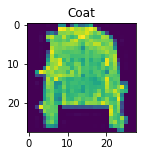

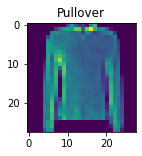

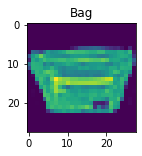

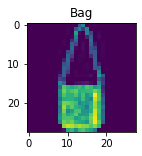

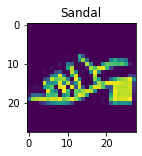

In [70]:
X_train, Y_train = load_mnist('fashion-mnist', kind='train')
mask = list(range(len(ds_train)))
X_train = X_train[mask]

for i in range(5):
    idx = np.random.randint(0, len(ds_train))
    img, label = X_train[idx], Y_train[idx]
    img = img.reshape((28, 28))
    plt.figure(figsize = (2,2))
    plt.title(f'{FASHION_MNIST_CLASSES[label]}')
    plt.imshow(img)

# Classification

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
device

device(type='cuda', index=0)

In [73]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=64, 
                                               shuffle=True,
                                               num_workers=1)

In [74]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=5, 
                                               shuffle=False,
                                               num_workers=1)

In [75]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    losses_plot = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
        losses_plot.append(loss.detach().item())

    return torch.stack(losses).mean().item(), losses_plot

In [76]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0))
        y_score = np.zeros((0,10))
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        
        B = y_true.shape[0]
        y_true_one_hot = np.zeros((B, 10))
        y_true_one_hot[np.arange(B), y_true.astype(np.int16)] = 1

        for i in range(10):
            ap = average_precision_score(y_true_one_hot[:, i], y_score[:, i])
            if print_ind_classes:
                print(f'-------  Class: {i}     AP: {ap:>8.4f}  -------')
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

## Modifying the network 

You are given couple network architectures (fully connected and convolutional). The goal of this assignment is to run the model of three architectures of your choice and repor the performance. In the results. 
There are a variety of different approaches you should try:

* Network architecture changes
* Number of layers: try adding layers to make your network deeper




In [77]:
classifier = Classifier().to(device)
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('voc_classifier.pth'))

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)

In [80]:
# Training the Classifier
NUM_EPOCHS = 8
TEST_FREQUENCY = 2
mAp = []
loss = []
curr_val = -1
best_model = []

for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss, losses = train_classifier(train_loader, classifier, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch%TEST_FREQUENCY==0):
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)

        if curr_val < mAP_val:
            curr_val = mAP_val
            best_model = classifier
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        

Starting epoch number 1
Loss for Training on Epoch 1 is 0.30720043182373047
Starting epoch number 2
Loss for Training on Epoch 2 is 0.28961485624313354
-------  Class: 0     AP:   0.8772  -------
-------  Class: 1     AP:   0.9912  -------
-------  Class: 2     AP:   0.8006  -------
-------  Class: 3     AP:   0.9212  -------
-------  Class: 4     AP:   0.8329  -------
-------  Class: 5     AP:   0.9805  -------
-------  Class: 6     AP:   0.6371  -------
-------  Class: 7     AP:   0.8605  -------
-------  Class: 8     AP:   0.9932  -------
-------  Class: 9     AP:   0.9884  -------
mAP: 0.8883
Avg loss: 0.3161021495177597
Evaluating classifier
Mean Precision Score for Testing on Epoch 2 is 0.8882745651621118
Starting epoch number 3
Loss for Training on Epoch 3 is 0.2739304006099701
Starting epoch number 4
Loss for Training on Epoch 4 is 0.26446065306663513
-------  Class: 0     AP:   0.9032  -------
-------  Class: 1     AP:   0.9914  -------
-------  Class: 2     AP:   0.8396  ----

In [32]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './fashion_mnist_classifier.pth')

# Evaluate on test set



In [83]:
ds_test = fashion_mnist_dataset('test', test_transform)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

-------  Class: 0     AP:   0.8954  -------
-------  Class: 1     AP:   0.9933  -------
-------  Class: 2     AP:   0.8087  -------
-------  Class: 3     AP:   0.9471  -------
-------  Class: 4     AP:   0.8113  -------
-------  Class: 5     AP:   0.9480  -------
-------  Class: 6     AP:   0.6683  -------
-------  Class: 7     AP:   0.8627  -------
-------  Class: 8     AP:   0.9879  -------
-------  Class: 9     AP:   0.9848  -------
mAP: 0.8907
Avg loss: 0.3156246036104858


In [85]:
output_submission_csv('my_solution.csv', test_aps)